In [0]:
import pymc3

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.datasets import load_diabetes
from sklearn.utils import shuffle

data = load_diabetes()
frame = pd.DataFrame(data.data, columns=data.feature_names)
frame['target'] = data.target

frame = shuffle(frame, random_state=0)

display(frame.head())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
362,0.019913,0.050680,0.104809,0.070073,-0.035968,-0.026679,-0.024993,-0.002592,0.003712,0.040343,321.0
249,-0.012780,-0.044642,0.060618,0.052858,0.047965,0.029375,-0.017629,0.034309,0.070211,0.007207,215.0
271,0.038076,0.050680,0.008883,0.042530,-0.042848,-0.021042,-0.039719,-0.002592,-0.018118,0.007207,127.0
435,-0.012780,-0.044642,-0.023451,-0.040099,-0.016704,0.004636,-0.017629,-0.002592,-0.038459,-0.038357,64.0
400,-0.023677,-0.044642,0.045529,0.090730,-0.018080,-0.035447,0.070730,-0.039493,-0.034524,-0.009362,175.0


In [0]:
split = len(frame) // 2
train = frame[:split]
test = frame[split:]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, delta, gamma, beta, alpha]
100%|██████████| 3000/3000 [00:50<00:00, 59.94it/s] 


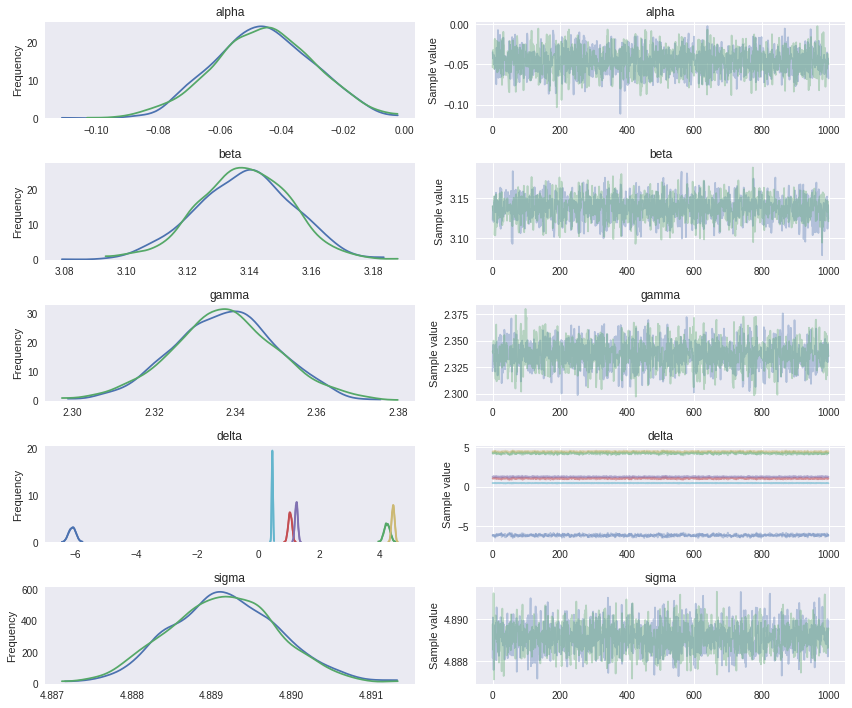

In [4]:
model = pymc3.Model()

s_features = ['s' + str(index) for index in range(1, 7)]

with model:
  alpha = pymc3.Normal('alpha')
  beta = pymc3.Normal('beta')
  gamma = pymc3.Normal('gamma')
  delta = pymc3.Normal('delta', shape=len(s_features))
  sigma = pymc3.Normal('sigma')
  Y = sigma + alpha * train.age + pymc3.math.switch(train.sex > 0, beta, gamma) * (train.bmi + train.bp) + pymc3.math.dot(train[s_features], delta)
  observations = pymc3.Normal('observed', mu=Y, sd=1e-2, observed=np.log(train.target))
  
  trace = pymc3.sample(1000, tune=2000, verbose=False)
  pymc3.traceplot(trace)

In [5]:
traced = {estimate:trace[estimate].mean(axis=0) for estimate in ['alpha', 'beta', 'gamma', 'delta', 'sigma']}
traced

{'alpha': -0.046009874886473415,
 'beta': 3.138024029850218,
 'delta': array([-6.112249  ,  4.2383513 ,  1.04920717,  1.25800666,  4.43740408,
         0.46542733]),
 'gamma': 2.337228014129272,
 'sigma': 4.889150718037094}

In [6]:
prediction = traced['sigma'] * np.array([1] * len(test)) + traced['alpha'] * test.age + (test.bmi + test.bp) * np.array([
    traced['beta'] if test.sex.values[index] > 0 else traced['gamma'] for index in range(len(test))
]) + np.dot(test[s_features], traced['delta'])

print("%.4f" % r2_score(test.target, np.exp(prediction)))

0.5035


In [7]:
from sklearn.linear_model import BayesianRidge
linear = BayesianRidge().fit(train[data.feature_names], train.target)
print("%.4f" % r2_score(test.target, linear.predict(test[data.feature_names])))

0.5347


In [8]:
from sklearn.ensemble import GradientBoostingRegressor
trees = GradientBoostingRegressor(random_state=0).fit(train[data.feature_names], train.target)
print("%.4f" % r2_score(test.target, trees.predict(test[data.feature_names])))

0.4169
